In [1]:
# filter some warning messages
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import xarray as xr
import pandas as pd

import os
import pickle

In [3]:
datapd = pd.read_csv('List57.csv')

In [4]:
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.colors as mc
from matplotlib import cm
from matplotlib.patches import Rectangle
from matplotlib.ticker import FuncFormatter

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import cmocean
import colorsys

from adjustText import adjust_text

In [5]:
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

In [6]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.
    
    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    c = np.array(colorsys.rgb_to_hls(*mc.to_rgb(color)))
    return colorsys.hls_to_rgb(c[0],1-amount * (1-c[1]),c[2])

In [10]:
# new color from https://colorbrewer2.org/
colors = ['#8dd3c7','#ffffb3','#bebada','#fb8072','#d9d9d9','#fdb462','#fccde5','#b3de69','#80b1d3','#bc80bd','#ccebc5']
# colors = cm.get_cmap("Set3").colors
types = datapd['type'].unique()
color_dict = {}
if len(colors) >= len(types):
    print('create new color dict')
    for i in range(len(types)):
        color_dict[types[i]] = colors[i] #lighten_color(colors[i], 0.6)

create new color dict


In [7]:
def newxy_fmissingxy(dx, dy):
    dx = dx.where((dx>-361) & (dx<361))
    dy = dy.where((dy>-91) & (dy<91))
    newx0 = dx[~np.isnan(dx).any(axis=1)][0]
    newy0 = dy[:, ~np.isnan(dy).any(axis=0)][:,0]
    newx, newy = np.meshgrid(newx0, newy0)
    x = np.where(np.isnan(dx), newx, dx)
    y = np.where(np.isnan(dy), newy, dy)
    return x, y

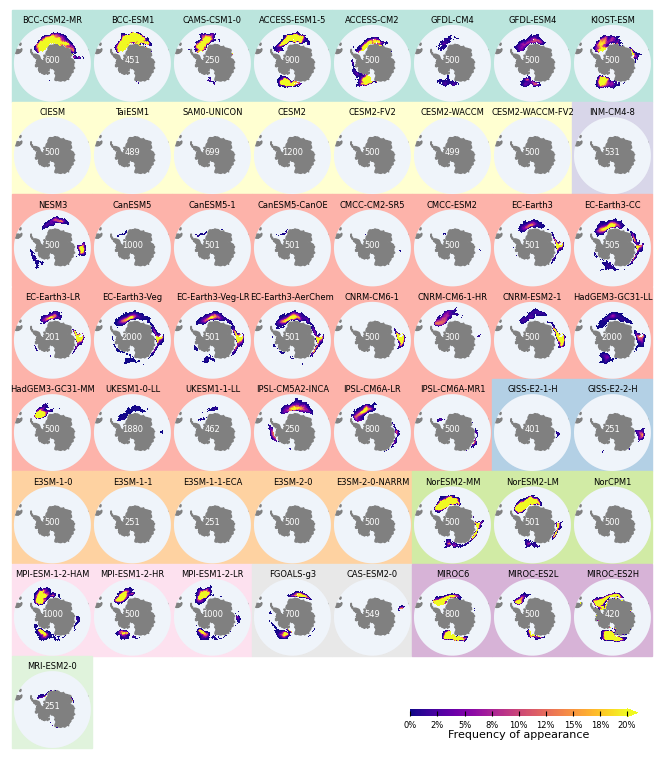

In [36]:
fig = plt.figure(figsize=(6.5, 7.5))
n = 0
for i in range(0, len(datapd)):
    name = datapd.at[i, 'source_id']
    pltd_name = '../../SO_data/data_polynya/' + name + '_mean.pickle'

    fpathst = '../../SO_data/data_mlotst/' + name + '.pickle'
    if os.path.exists(pltd_name):
        n = n + 1
        if not os.path.exists(fpathst):
            ## if no mlotst, use mld calculated by me
            fpathst = '../../SO_data/data_mld/' + name + '.pickle'     
        ds = pd.read_pickle(fpathst)
        
        if not pd.isna(datapd.at[i, 'latname']) and (name != 'CAS-ESM2-0'):
            dlat = ds[datapd.at[i, 'latname']].load()
            dlon = ds[datapd.at[i, 'lonname']].load()
            dlat = dlat.where(dlat <= 90).where(dlat>=-90)
            dlon = dlon.where(dlon <= 360).where(dlon>=-360)
            pltx = dlon
            plty = dlat
            if np.isnan(dlat).any() or np.isnan(dlon).any():
                pltx, plty = newxy_fmissingxy(dlon, dlat)
        else:
            if name == 'CAS-ESM2-0':
                yname = 'lat'
                xname = 'lon'
            else:
                xname = datapd.at[i, 'xname']
                yname = datapd.at[i, 'yname']
            dx = ds[xname]
            dy = ds[yname]
            pltx, plty = np.meshgrid(dx, dy)

        ax = fig.add_subplot(8, 8, n, projection=ccrs.SouthPolarStereo())
        plt.subplots_adjust(left=0.01,
                            bottom=0.01, 
                            right=0.99, 
                            top=0.99, 
                            wspace=0.04, 
                            hspace=0.04)
        bbox = ax.get_position()
        t = datapd.at[i, 'type']
        rect = Rectangle((bbox.x0-0.002367,bbox.y0),
                         bbox.width+0.004734,bbox.height+0.02, 
                         fill=True, color=color_dict[t], alpha=1, zorder=-1,
                         transform=fig.transFigure, clip_on=False)
        fig.add_artist(rect)

        ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
        mld = ds

        pltm = xr.where(mld>=2000, 1, np.nan)
        pltf = pltm.sum('time')/len(pltm.time)
        pltf = pltf.where(pltf>0)
            
        ax.set_title('{}'.format(name), fontsize=6, pad=-0.5)
        ax.text(0,-90, str(len(ds.time)), fontsize=6, color='w', ha='center')

        ax.add_feature(cfeature.LAND, zorder=1, color = 'grey')
        ax.add_feature(cfeature.OCEAN, alpha = 0.15)
        ax.set_boundary(circle, transform=ax.transAxes)

        ax.spines['geo'].set_edgecolor(None)
        im2 = ax.pcolormesh(pltx, plty, pltf, vmin = 0, vmax=0.2, 
                           transform=ccrs.PlateCarree(), cmap=plt.cm.plasma)

# cbar_ax2 = fig.add_axes([0.20, 0.07, 0.35, 0.01])
# cbar2 = fig.colorbar(im2, cax=cbar_ax2, orientation='horizontal', extend='max', drawedges=False)
# cbar2.set_label('Frequency of appearance', size=8, labelpad=-0.1)
# cbar2.ax.tick_params(labelsize=6, direction='in')

cbar_ax2 = fig.add_axes([0.62, 0.06, 0.35, 0.01])
cbar2 = fig.colorbar(im2, cax=cbar_ax2, 
                     orientation='horizontal', 
                     extend='max')
cbar2.set_label('Frequency of appearance', size=8, labelpad=-0.1)
cbar2.ax.tick_params(labelsize=6, direction='in')
cbar2.outline.set_visible(False)
def to_percentage(x, pos):
    return f"{x * 100:.0f}%"

cbar2.formatter = FuncFormatter(to_percentage)
cbar2.update_ticks()

fig.savefig('DeepConvection_Multi.png', dpi = 300)
# fig.savefig('DeepConvection_Multi.eps', format='eps')  # too big (should be less than 5MB
# fig.savefig('DeepConvection_Multi.pdf', format='pdf')  # too big (should be less than 5MB

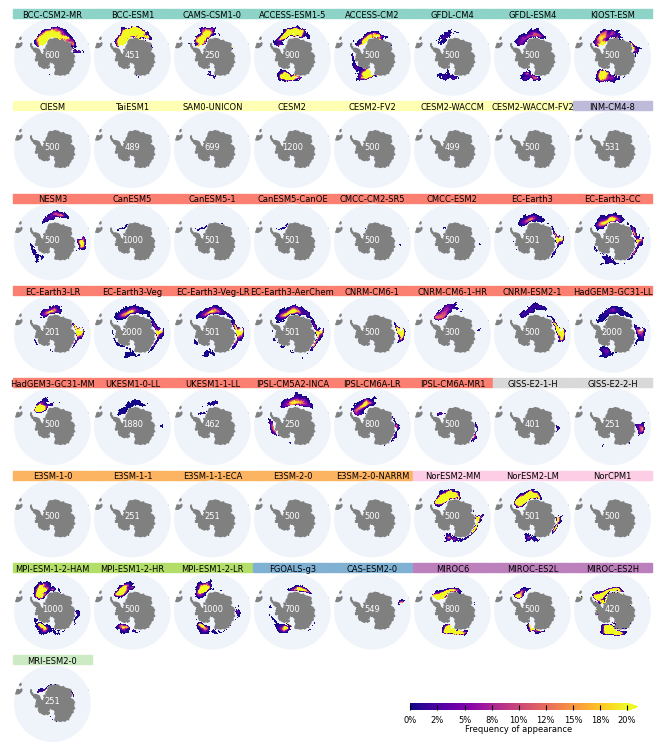

In [11]:
fig = plt.figure(figsize=(6.5, 7.5))
n = 0
for i in range(0, len(datapd)):
    name = datapd.at[i, 'source_id']
    pltd_name = '../../SO_data/data_polynya/' + name + '_mean.pickle'

    fpathst = '../../SO_data/data_mlotst/' + name + '.pickle'
    if os.path.exists(pltd_name):
        n = n + 1

        if not os.path.exists(fpathst):
            ## if no mlotst, use mld calculated by me
            fpathst = '../../SO_data/data_mld/' + name + '.pickle'     
        ds = pd.read_pickle(fpathst)
        
        if not pd.isna(datapd.at[i, 'latname']) and (name != 'CAS-ESM2-0'):
            dlat = ds[datapd.at[i, 'latname']].load()
            dlon = ds[datapd.at[i, 'lonname']].load()
            dlat = dlat.where(dlat <= 90).where(dlat>=-90)
            dlon = dlon.where(dlon <= 360).where(dlon>=-360)
            pltx = dlon
            plty = dlat
            if np.isnan(dlat).any() or np.isnan(dlon).any():
                pltx, plty = newxy_fmissingxy(dlon, dlat)
        else:
            if name == 'CAS-ESM2-0':
                yname = 'lat'
                xname = 'lon'
            else:
                xname = datapd.at[i, 'xname']
                yname = datapd.at[i, 'yname']
            dx = ds[xname]
            dy = ds[yname]
            pltx, plty = np.meshgrid(dx, dy)

        ax = fig.add_subplot(8, 8, n, projection=ccrs.SouthPolarStereo())
        plt.subplots_adjust(left=0.01,
                            bottom=0.01, 
                            right=0.99, 
                            top=0.99, 
                            wspace=0.04, 
                            hspace=0.04)
        bbox = ax.get_position()
        t = datapd.at[i, 'type']
        rect = Rectangle((bbox.x0-0.002,bbox.y1+0.001),
                         bbox.width+0.004, 0.012, 
                         fill=True, color=color_dict[t], alpha=1, zorder=-1,
                         transform=fig.transFigure, clip_on=False)
        fig.add_artist(rect)

        ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
        mld = ds

        pltm = xr.where(mld>=2000, 1, np.nan)
        pltf = pltm.sum('time')/len(pltm.time)
        pltf = pltf.where(pltf>0)
            
        title = ax.set_title('{}'.format(name), 
                             fontsize=6, pad=-0.5)
        # title._bbox_patch._mutation_aspect = 1
        # title.get_bbox_patch().set_boxstyle("square", pad=11.9)
        ax.text(0,-90, str(len(ds.time)), fontsize=6, color='w', ha='center')

        ax.add_feature(cfeature.LAND, zorder=1, color = 'grey')
        ax.add_feature(cfeature.OCEAN, alpha = 0.15)
        ax.set_boundary(circle, transform=ax.transAxes)

        ax.spines['geo'].set_edgecolor(None)
        im2 = ax.pcolormesh(pltx, plty, pltf, vmin = 0, vmax=0.2, 
                           transform=ccrs.PlateCarree(), cmap=plt.cm.plasma)

# cbar_ax2 = fig.add_axes([0.20, 0.07, 0.35, 0.01])
# cbar2 = fig.colorbar(im2, cax=cbar_ax2, orientation='horizontal', extend='max', drawedges=False)
# cbar2.set_label('Frequency of appearance', size=8, labelpad=-0.1)
# cbar2.ax.tick_params(labelsize=6, direction='in')

cbar_ax2 = fig.add_axes([0.62, 0.06, 0.35, 0.01])
cbar2 = fig.colorbar(im2, cax=cbar_ax2, 
                     orientation='horizontal', 
                     extend='max')
cbar2.set_label('Frequency of appearance', size=6, labelpad=-0.1)
cbar2.ax.tick_params(labelsize=6, direction='in')
cbar2.outline.set_visible(False)
def to_percentage(x, pos):
    return f"{x * 100:.0f}%"

cbar2.formatter = FuncFormatter(to_percentage)
cbar2.update_ticks()

fig.savefig('DeepConvection_Multi_title.png', dpi = 300)
# fig.savefig('DeepConvection_Multi.eps', format='eps')  # too big (should be less than 5MB
# fig.savefig('DeepConvection_Multi.pdf', format='pdf')  # too big (should be less than 5MB

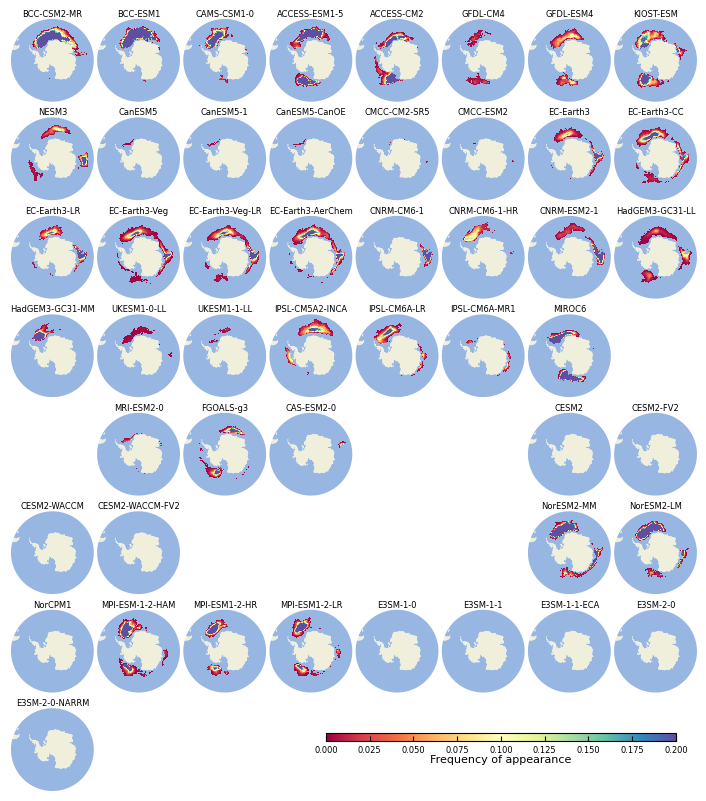

In [22]:
fig = plt.figure(figsize=(7, 8))

n = 0

# newcmap = cmocean.tools.crop_by_percent(cmocean.cm.matter, 20, which='min', N=None)
for i in range(0, len(datapd)):
    name = datapd.at[i, 'source_id']
    # pltd_dict = {'pltd':pltd, 'pld_pc':pltd_pc,'pltx':pltx, 'plty':plty}

    pltd_name = '../../SO_data/data_polynya/' + name + '_mean.pickle'


    fpathst = '../../SO_data/data_mlotst/' + name + '.pickle'

    if os.path.exists(pltd_name):
        n = n + 1
        if not os.path.exists(fpathst):
            continue
            
        ds = pd.read_pickle(fpathst)
        
        if not pd.isna(datapd.at[i, 'latname']) and (name != 'CAS-ESM2-0'):
            dlat = ds[datapd.at[i, 'latname']].load()
            dlon = ds[datapd.at[i, 'lonname']].load()
            dlat = dlat.where(dlat <= 90).where(dlat>=-90)
            dlon = dlon.where(dlon <= 360).where(dlon>=-360)
            pltx = dlon
            plty = dlat
            if np.isnan(dlat).any() or np.isnan(dlon).any():
                pltx, plty = newxy_fmissingxy(dlon, dlat)

        else:
            if name == 'CAS-ESM2-0':
                yname = 'lat'
                xname = 'lon'
            else:
                xname = datapd.at[i, 'xname']
                yname = datapd.at[i, 'yname']
            dx = ds[xname]
            dy = ds[yname]
            pltx, plty = np.meshgrid(dx, dy)

        
        ax = fig.add_subplot(8, 8, n, projection=ccrs.SouthPolarStereo())
        plt.subplots_adjust(left=0.01,
                            bottom=0.01, 
                            right=0.99, 
                            top=0.99, 
                            wspace=0.04, 
                            hspace=0.04)
        # fig.subplots_adjust(wspace=0.04, hspace=0.12)
        ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
        mld = ds

        pltm = xr.where(mld>=2000, 1, np.nan)
        pltf = pltm.sum('time')/len(pltm.time)
        pltf = pltf.where(pltf>0)


        # gl = ax.gridlines(
        #     xlocs = np.arange(-180,180,90), 
        #     ylocs = np.arange(-90,90,20),
        #     draw_labels=False, y_inline=True)
            
        ax.set_title('{}'.format(name), fontsize=6, pad=-0.5)
        
    
        # im = ax.pcolormesh(pltx, plty, pltm, vmin = 0, vmax=1.2, 
        #                    transform=ccrs.PlateCarree(), cmap=plt.cm.gray)
        ax.add_feature(cfeature.LAND, zorder=1)
        ax.add_feature(cfeature.OCEAN)
        ax.set_boundary(circle, transform=ax.transAxes)
        # ax.outline_patch.set_visible(False)
        # ax.outline_patch.set_edgecolor('white')
        ax.spines['geo'].set_edgecolor(None)
        im2 = ax.pcolormesh(pltx, plty, pltf, vmin = 0, vmax=0.2, 
                           transform=ccrs.PlateCarree(), cmap=plt.cm.Spectral)
        # cbar = plt.colorbar(im) 

        
        # newcmap = cmocean.tools.crop_by_percent(cmocean.cm.speed_r, 50, which='min', N=None)
        # im2 = ax.pcolormesh(pltx, plty, pltd_pc, 
        #                     transform=ccrs.PlateCarree(), 
        #                     vmin = 0, vmax = 0.20, cmap=plt.cm.Spectral)
        # ax.add_feature(cfeature.LAND, zorder=1)#, color='0.8')
        # ax.add_feature(cfeature.COASTLINE, linewidth=0.2)
        # ax.set_boundary(circle, transform=ax.transAxes)

        # if n > 3:
        #     break 


# cbar_ax1 = fig.add_axes([0.46, 0.11, 0.50, 0.01])
# cbar1 = fig.colorbar(im, cax=cbar_ax1, orientation='horizontal')
# cbar1.set_label('Maximum sea ice coverage (%)', size=8, labelpad=-0.1)
# cbar1.ax.tick_params(labelsize=6,direction='in')

cbar_ax2 = fig.add_axes([0.46, 0.08, 0.50, 0.01])
cbar2 = fig.colorbar(im2, cax=cbar_ax2, orientation='horizontal', extend='max')
cbar2.set_label('Frequency of appearance', size=8, labelpad=-0.1)
cbar2.ax.tick_params(labelsize=6,direction='in')

# fig.savefig('DeepConvection_Multi.png', dpi = 300)
